In [0]:
import geopandas
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import metrics
from sklearn import model_selection
from sklearn import kernel_ridge
from sklearn import svm
from sklearn import tree
from sklearn import dummy
from sklearn import covariance
from sklearn import feature_selection
from sklearn import ensemble
from scipy import stats
import matplotlib.pyplot as plt
import pickle

from matplotlib.ticker import FormatStrFormatter

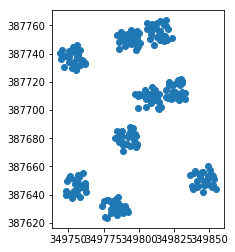

In [2]:
fw_pts = geopandas.read_file('/Volumes/Gibbs_Drive/Data_Master/Points_S2_VI_S1_BP_S2RAT_S1RAT.shp')
points = fw_pts
print(' ')
points.plot()

In [0]:
#Names of the independent variables that will be predicted:
y_col_names = ['Dry_wgh', 'Frsh_wg', 'FDN', 'FDA', 'CP', 'DIVMS']
y_col_full_names = ['Dry Weight Biomass', 'Fresh Weight Biomass', 'Neutral Detergent Fiber', 'Acid Detergent Fiber', 'Crude Protein', 'In-Vitro Dry Matter Digestibility']

#Names of the predictor variables
X_col_names = list(points)[23:(len(list(points))-1)]
X = points.loc[:, X_col_names]

In [0]:
def evaluate_model(reg, X_scaled, y_scaled):
  #previously used: neg_mean_squared_error
  mse_scores = model_selection.cross_validate(reg, X_scaled, y_scaled, scoring='neg_median_absolute_error', cv=5)
  mse_scores = mse_scores['test_score']
  
  X_train, X_test, y_train, y_test = model_selection.train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=0)
  reg.fit(X_train, y_train)
  pred = reg.predict(X_test)
  r2 = metrics.r2_score(y_test, pred)
  return(mse_scores.mean(), r2)

In [0]:
def plot_model_genotypes(reg, var):
  
  genotypes = points['Genotyp'].unique()

  X_scaled = points.loc[:, X_col_names]

  for col in list(X_scaled):
    X_scaled.loc[:, col] = preprocessing.scale(np.array(X_scaled.loc[:, col]))
  X_scaled = X_scaled.to_numpy()

  y = np.array(points.loc[:, var])
  y_scaled = preprocessing.scale(y)
  y_scaled = np.ravel(y_scaled)
  
  X_train, X_test, y_train, y_test = model_selection.train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=0)
  reg.fit(X_train, y_train)
  pred = reg.predict(X_test)

  Prediction_Genotypes = pd.DataFrame({'Ground_Truth': y_test, 'Prediction': pred, 'Genotyp': points.loc[y_train.shape[0]:, 'Genotyp']})


  colors = ['green', 'blue', 'red']

  for i, gtp in enumerate(genotypes):
    plt.scatter(Prediction_Genotypes.loc[Prediction_Genotypes['Genotyp'] == gtp, 'Ground_Truth'].index,
                np.sort(Prediction_Genotypes.loc[Prediction_Genotypes['Genotyp'] == gtp, 'Ground_Truth']), 
                color=colors[i], s=10, label=gtp)
  
    plt.scatter(Prediction_Genotypes.loc[Prediction_Genotypes['Genotyp'] == gtp, 'Prediction'].index,
                np.sort(Prediction_Genotypes.loc[Prediction_Genotypes['Genotyp'] == gtp, 'Prediction']), 
                facecolors='none', edgecolors=colors[i], s=10, label='_nolegend_')

  plt.scatter(None, None, facecolors='none', edgecolors='grey', s=10, label='Prediction')

  plt.legend()
  plt.show()
  

In [0]:
def plot_model(reg, var):
  
  var_pairs = zip(y_col_names, y_col_full_names)
  
  for pair in var_pairs:
    if var == pair[0]:
      var_full_name = pair[1]
  
  X_scaled = points.loc[:, X_col_names]

  for col in list(X_scaled):
    X_scaled.loc[:, col] = preprocessing.scale(np.array(X_scaled.loc[:, col]))
  X_scaled = X_scaled.to_numpy()

  y = np.array(points.loc[:, var])
  y_scaled = preprocessing.scale(y)
  y_scaled = np.ravel(y_scaled)
  
  X_train, X_test, y_train, y_test = model_selection.train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=0)
  reg.fit(X_train, y_train)
  pred = reg.predict(X_test)

  
  pred_df = pd.DataFrame({'Ground_Truth': y_test, 'Prediction': pred})
  pred_df = pred_df.sort_values('Prediction', axis=0)

  
  fig1 = plt.figure(1)

  frame1=fig1.add_axes((.1,.3,.8,.6))

  x = range(0, len(y_test))

  plt.plot(x,pred_df['Ground_Truth'],'.b', markersize=3, label='Observed')
  plt.plot(x,pred_df['Prediction'],'-r', linewidth=1, label='Predicted')
  frame1.set_xticklabels([])
  frame1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
  plt.ylabel('Scaled Data Value', labelpad=5)
  plt.title(var_full_name)
  plt.legend()
  plt.grid()

  #Residual Plot
  difference = pred_df['Ground_Truth'] - pred_df['Prediction']
  frame2=fig1.add_axes((.1,.1,.8,.2))        
  plt.plot(x,difference,'.k', markersize=5)
  frame2.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
  plt.yticks((1, 0, -1)) 
  
  plt.ylabel('Residuals', labelpad=5)
  
  plt.xlabel('Number of Observations')
  plt.grid()
  
  path = '/Volumes/Gibbs_Drive/Thesis_Graphs/Regression Graphs/'
  im_name = path + var + '.png'
  plt.savefig(im_name, dpi=900)
  plt.close()

In [0]:
for variable in y_col_names:
  plot_model(ensemble.RandomForestRegressor(n_estimators=10), variable)

In [0]:
#Do for each reg var pair

reg_var_pairs = [(kernel_ridge.KernelRidge(), 'Dry_wgh'),
                 (kernel_ridge.KernelRidge(), 'Frsh_wg'),
                 (ensemble.RandomForestRegressor(n_estimators=10), 'FDN'),
                 (ensemble.RandomForestRegressor(n_estimators=10), 'FDA'),
                 (ensemble.RandomForestRegressor(n_estimators=10), 'CP'),
                 (ensemble.RandomForestRegressor(n_estimators=10), 'DIVMS')]

for pair in reg_var_pairs:
  reg = pair[0]
  var = pair[1]
  
  plot_model(reg, var)